# Description:

* For emperical data, most taxa (>0.1% abundance) are detected across the entire gradient.
* Checking whether a similar pattern is seen with the simulated genome data

# Setting variables

In [164]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/validation/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figDir = '/home/nick/notebook/SIPSim/figures/'

nprocs = 3

# Init

In [165]:
import os
import numpy as np
import dill
import pandas as pd
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [166]:
%%R
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(gridExtra)

In [167]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

## Determining the probability of detecting the taxa across the entire gradient

In [168]:
# max 13C shift
max_13C_shift_in_BD = 0.036
# min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
# max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD
## BD range of values
BD_vals = np.arange(min_BD, max_BD, 0.001)

### skewed normal distribution

In [169]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f3a34792310>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f3a34792250>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f3a34792190>}

In [170]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [171]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.000517,0.000500,0.000002,1.67323
1,0.000725,0.000450,0.000008,1.67423
2,0.001150,0.000382,0.000025,1.67523


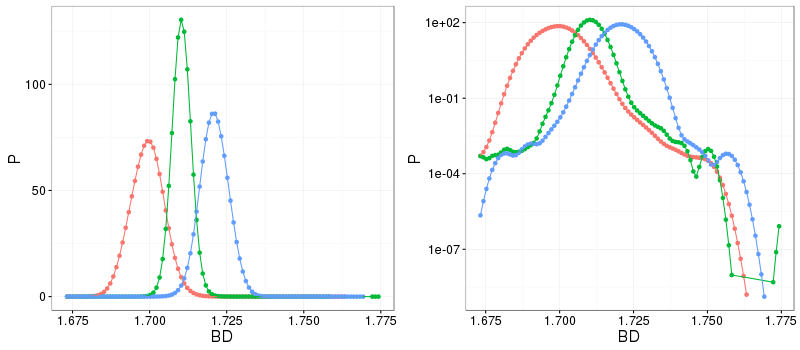

In [172]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

### small uniform distribution

In [173]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f3a3476e990>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f3a3476ef90>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f3a3476e310>}

In [174]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [175]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.001166,0.000002,6.171153e-10,1.67323
1,0.002241,0.000005,2.971985e-09,1.67423
2,0.004180,0.000012,1.311572e-08,1.67523


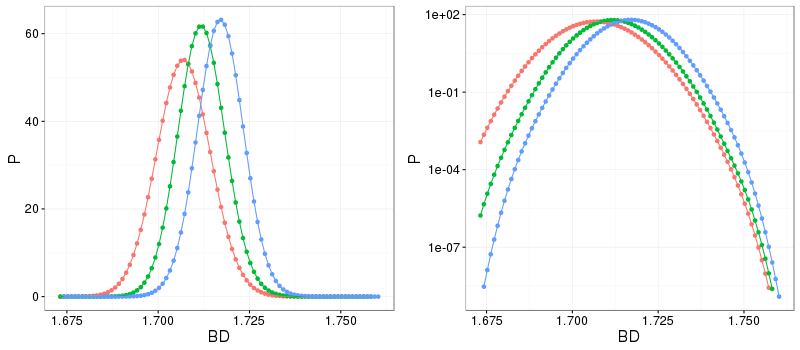

In [176]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even with fragment sizes of 1-2 kb, the taxa would likely not be detected even if the gradient contained 1e9 16S copies of the taxon.
  * Does this make sense based on the theory of diffusion used?

# with DBL 'smearing'

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [177]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [178]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f3a347a0550>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f3a3477f2d0>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f3a347a0590>}

In [179]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [180]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.015230,0.008565,0.007630,1.67323
1,0.022305,0.008410,0.007600,1.67423
2,0.036630,0.007919,0.007453,1.67523


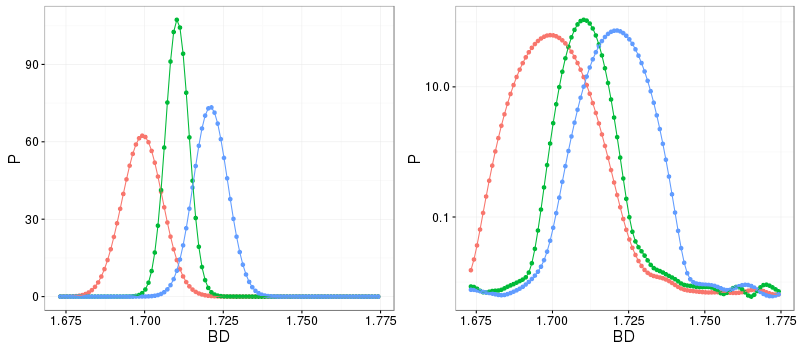

In [181]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even if 1% of DNA is in DBL (that then diffuses back into the gradient):
  * the probably of detecting a taxa in all the gradient positions is >= 1e-7
    * this is feasible for matching the emperical data!

### small fragment size distribution

In [182]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [183]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f3a3477f150>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f3a3477f910>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f3a3477f990>}

In [184]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [185]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.026638,0.005452,0.006099,1.67323
1,0.038696,0.005557,0.005922,1.67423
2,0.056851,0.005849,0.005744,1.67523


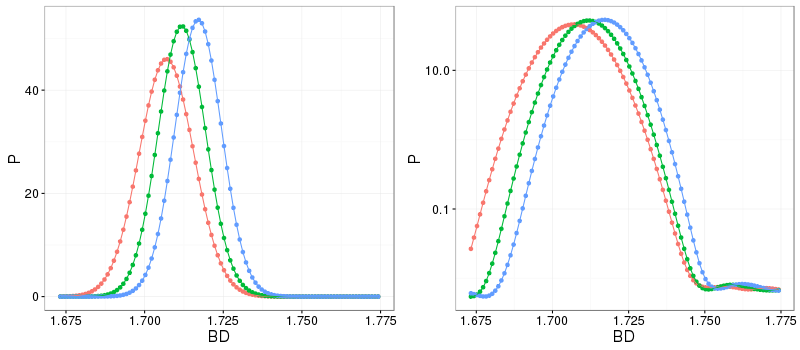

In [186]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

# with DBL 'smearing' (smaller DBL)

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [187]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [188]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL_fa1e-4.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f3a34792c50>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f3a34792890>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f3a34792b90>}

In [189]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [190]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.005853,0.001616,0.000831,1.67323
1,0.012118,0.001567,0.000943,1.67423
2,0.024758,0.001392,0.001051,1.67523


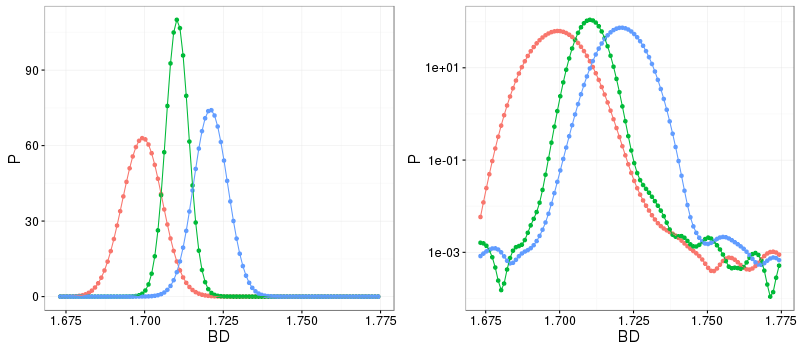

In [191]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)